In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL-H1/

Mounted at /gdrive
/gdrive/My Drive/ANNDL-H1


# Stuff Tried For Model2
- **model2_Base** -> 55%
- **model2_BatchNormalization** -> 60% accuracy
- **model2_GlobalAvgpooling1** -> Accuracy: 0.6751,Precision: 0.651,Recall: 0.6307,F1: 0.6353
- **model2_GlobalAvgpooling3** -> AccurAccuracy: 0.6469,Precision: 0.6141,Recall: 0.5935,F1: 0.5984
- **model2_GlobalAvgpooling4_MaxPooling** -> AccurAccuracy: 0.655,Precision: 0.6095,Recall: 0.0.6006,F1: 0.6000
- **model2_GlobalAvgpooling4_Batch(no multiConv)**-> AccurAccuracy: 0.678,Precision: 0.6658,Recall: 0.0.6449,F1: 0.6241
- **model2_GlobalAvgpooling6_BestVersion(added batch between dense)**-> AccurAccuracy: 0.6808,Precision: 0.6414,Recall: 0.0.6306,F1: 0.6299 


BAD: Double CONV on first,second layer dosnt work\
BAD: Triple CONV on third and forth dosnt work (stuck to 10%)\
BAD: Droppout after global avg pooling dosnt work\
BAD: Batch Normalization on Convolutions dosnt work well\


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
!pip install visualkeras
import visualkeras
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
%load_ext autoreload
%autoreload 2

2.10.0


In [1]:
import sys
sys.path.append('../../../Utils/')
from DatasetHelper import DatasetHelper
from ModelHelper import ModelHelper

## Helper Configuration:
Configure
 the helper classes by setting a seed and the root folder path

In [2]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../",42) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("../../",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);

NameError: name 'tf' is not defined

# Dataset Loading and Preprocessing

Load dataset and apply all the preprocessing operations
- Splitting
- Normalization
- Augmentation

In [ ]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
#X,Y = dataset_helper.load_Dataset(22)

dataset_size = X.shape[0]
print("Dataset Size" + str(dataset_size))

#SPLIT and NORMALIZE OUR DATASET
X_train,X_test,X_val,Y_train,Y_test,Y_val = dataset_helper.split_and_normalize(X,Y,split_test=0.1,split_val=0.1,normalization_mode = 1)

#GENERATE 3000 new images
#X_train,Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train,Y_train,1000,[0.3,0.05,0.05,0.05,0.05,0.3,0.05,0.05])
X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_train,Y_train,4000, disable_tqdm=True)


Dataset Size3542
Data Augmentation with data distribution
Data distribution = [0.16675 0.11055 0.11315 0.11395 0.11075 0.16075 0.10975 0.11435]
Class Size :  151, generating: 833
787 images generated
Class Size :  432, generating: 552
528 images generated
Class Size :  419, generating: 565
515 images generated
Class Size :  415, generating: 569
543 images generated
Class Size :  431, generating: 553
527 images generated
Class Size :  181, generating: 803
756 images generated
Class Size :  436, generating: 548
532 images generated
Class Size :  413, generating: 571
541 images generated


: 

: 

In [ ]:
start = 3000
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
classe = 2
filter_classes = False
for i in range(1, columns*rows +1):
    if not (filter_classes) or np.argmax(Y_train[start+i]) == classe:
        subplot = fig.add_subplot(rows, columns, i)
        subplot.title.set_text('Label: '+ labels[np.argmax(Y_train[start+i])])
        plt.imshow((X_train[start+i]*255).astype(np.uint8))
    else:
        i=i-1
fig.tight_layout()
plt.show()

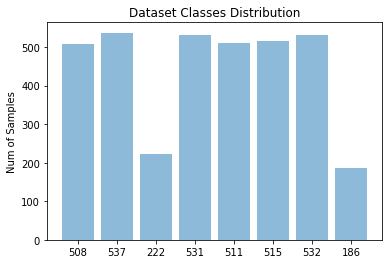

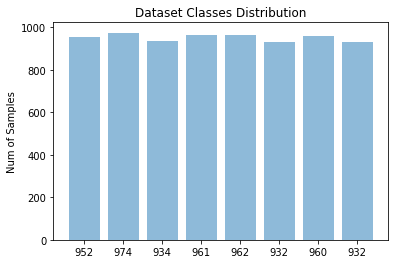

In [ ]:
dataset_helper.plot_samples_distribution(Y)
dataset_helper.plot_samples_distribution(Y_train)

# Define the model Structure
Create a function that declare all the model components

In [ ]:
def stackDenseLayer(layer_name,last_layer,size=256, activation='relu', drop_out = False,drop_rate=0.5,GlorthUniform=False,batch_normalization=False):
    initializer = tfk.initializers.HeUniform(seed)
    if GlorthUniform:
      initializer = tfk.initializers.GlorotUniform(seed)

    dense_layer = tfkl.Dense(
        units=size, 
        name=layer_name, 
        activation=activation,
        kernel_initializer = initializer #Can Be HeUniform(seed) or GlorotUniform(seed)
    )(last_layer)

    #If desired, apply batch normalization
    if batch_normalization:
      dense_layer = tfkl.BatchNormalization(
            axis=-1,
            momentum=0.99,
            epsilon=0.001,
            center=True,
            scale=True,
            beta_initializer="zeros",
            gamma_initializer="ones",
            moving_mean_initializer="zeros",
            moving_variance_initializer="ones"
        )(dense_layer)
    #If desired add droppout
    if drop_out:
        dense_layer = tfkl.Dropout(drop_rate, seed=seed)(dense_layer)
    
    return dense_layer


In [ ]:
def stackConvolutionLayer(layer_name,last_layer,kernel_size = (3,3), num_of_filter = 32,strides= (1,1),activation = 'relu',padding = 'same',pooling_size=(2,2),batch_normalization=False,num_of_stacked_conv=1,Pool=True,PoolAvg=False):
    layer_activation = activation

    for i in range(0,num_of_stacked_conv):
        curr_name = layer_name + "_conv" + str(i)
        
        if batch_normalization and i == num_of_stacked_conv - 1:
            activation = None

        curr_conv =tfkl.Conv2D(
            filters=num_of_filter,
            kernel_size=kernel_size,
            strides = strides,
            padding = padding,
            activation = layer_activation,
            name=curr_name,
            kernel_initializer = tfk.initializers.HeUniform(seed)
        )(last_layer)

        if batch_normalization and i == num_of_stacked_conv-1: #Batch  true and last conv in layer
            batch = BatchNormalization()(curr_conv)
            activation = tfkl.Activation(layer_activation)(batch)
            curr_conv = activation

        last_layer = curr_conv

        if Pool:
          if PoolAvg:
            curr_conv = tfkl.AvgPool2D(pool_size = pooling_size)(last_layer)
          else:
            curr_conv = tfkl.MaxPooling2D(pool_size = pooling_size)(last_layer)

          

    return curr_conv

In [ ]:
from tensorflow.keras import layers
#Create the Model
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    layer_0 = stackConvolutionLayer('Layer0',input_layer,kernel_size=(7,7),num_of_filter=32,num_of_stacked_conv = 1,batch_normalization=False)

    layer_1 = stackConvolutionLayer('Layer1',layer_0,kernel_size=(5,5),num_of_filter=64,num_of_stacked_conv = 1,batch_normalization=False)

    layer_2 = stackConvolutionLayer('Layer2',layer_1,kernel_size=(3,3),num_of_filter=128,num_of_stacked_conv = 2,batch_normalization=False)
    
    layer_3 = stackConvolutionLayer('Layer3',layer_2,kernel_size=(3,3),num_of_filter=256,num_of_stacked_conv = 2,batch_normalization=False)
    
    layer_4 = stackConvolutionLayer('Layer4',layer_2,kernel_size=(3,3),num_of_filter=512,num_of_stacked_conv = 2,batch_normalization=False,Pool=True)
    
    flattening_layer_global_pool = tfkl.GlobalAveragePooling2D(name='GlobalAVGPool')(layer_3)
    #flattening_layer_global_pool = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(flattening_layer_global_pool)
    #flattening_layer = tfkl.Flatten(name='Flatten')(layer_3)

    classifier_layer0   = stackDenseLayer('Classifier_layer0',flattening_layer_global_pool ,size=512,drop_out=True,drop_rate=0.3,batch_normalization = False,GlorthUniform = True)
    classifier_layer1   = stackDenseLayer('Classifier_layer1',classifier_layer0,size=256,drop_out=True,drop_rate=0.2,batch_normalization = False,GlorthUniform = True)
    classifier_layer2   = stackDenseLayer('Classifier_layer2',classifier_layer1,size=64,drop_out=True,drop_rate=0.1,batch_normalization = True,GlorthUniform = True)

    
    output_layer = stackDenseLayer('Output',classifier_layer2,size=8,activation='softmax',GlorthUniform = True)
    

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

# Training Phase
Compile the model, configure all necessary infomation for training like epoch,batches, callbacks...
Then start the training

### Compile the model

In [2]:
#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 200

model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

NameError: name 'X_train' is not defined

### Train the model

In [ ]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,patience=15)

#Fit the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/200
60/60 [==============================] - 7s 101ms/step - loss: 2.3482 - accuracy: 0.1445 - val_loss: 3.8720 - val_accuracy: 0.1541
Epoch 2/200
60/60 [==============================] - 6s 94ms/step - loss: 1.9973 - accuracy: 0.1989 - val_loss: 2.3363 - val_accuracy: 0.2075
Epoch 3/200
60/60 [==============================] - 6s 94ms/step - loss: 1.9090 - accuracy: 0.2320 - val_loss: 2.1162 - val_accuracy: 0.1667
Epoch 4/200
60/60 [==============================] - 6s 94ms/step - loss: 1.8767 - accuracy: 0.2323 - val_loss: 2.0475 - val_accuracy: 0.2013
Epoch 5/200
60/60 [==============================] - 6s 94ms/step - loss: 1.8229 - accuracy: 0.2488 - val_loss: 2.5654 - val_accuracy: 0.1509
Epoch 6/200
60/60 [==============================] - 6s 94ms/step - loss: 1.8216 - accuracy: 0.2508 - val_loss: 3.8171 - val_accuracy: 0.1478
Epoch 7/200
60/60 [==============================] - 6s 95ms/step - loss: 1.7945 - accuracy: 0.2556 - val_loss: 2.4189 - val_accuracy: 0.1509
Epoch

In [ ]:
#model_helper.save_model(model,"model2_GlobalAvgpooling6_BestVersion")

model = model_helper.load_model("model2_GlobalAvgpooling6_BestVersion")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       73856 

12/12 [==============================] - 0s 9ms/step
Accuracy: 0.6808
Precision: 0.6414
Recall: 0.6306
F1: 0.6299


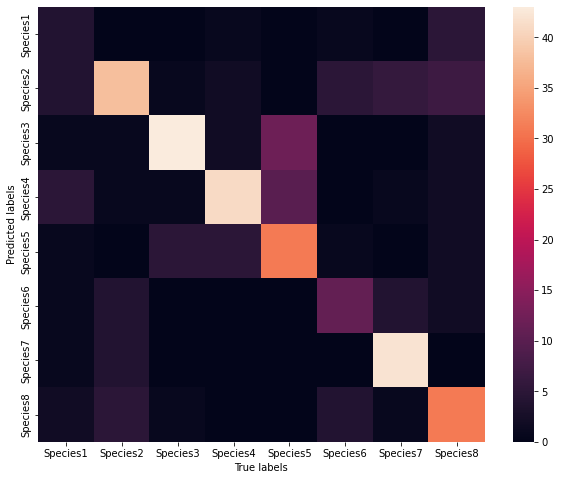

BABABA


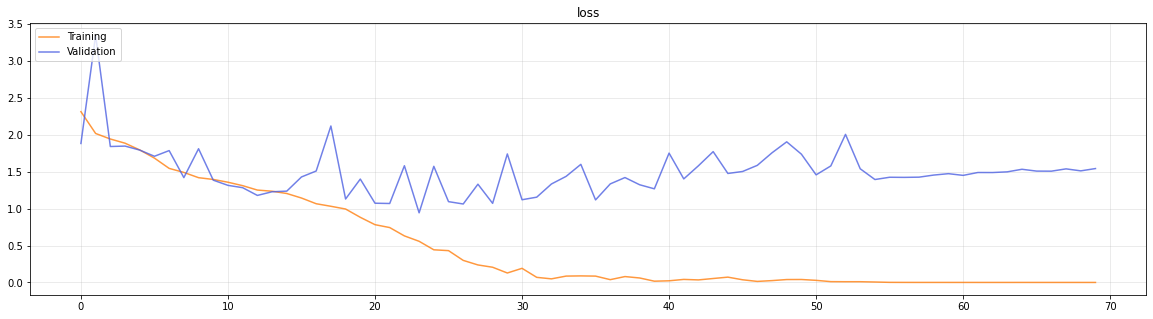

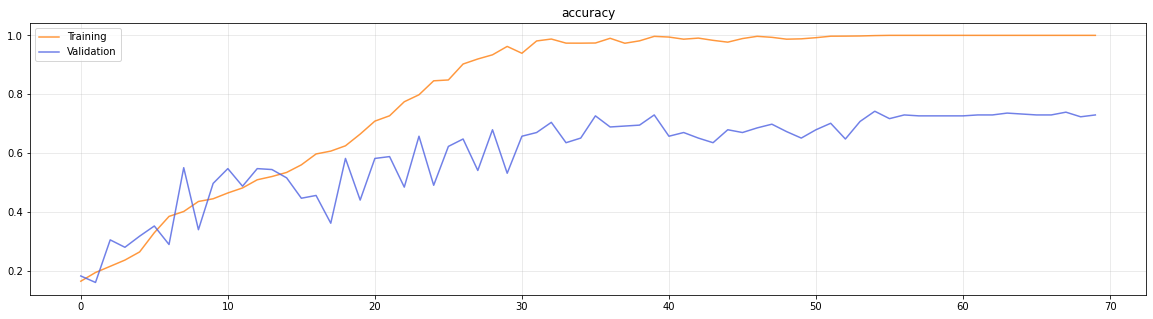

In [ ]:
model_helper.show_confusion_matrix(X_test,Y_test)
model_helper.plot_phase_train_vs_validation(history)